<a href="https://colab.research.google.com/github/SurapatNJ/dalle-mini/blob/main/tools/inference/inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [1]:
# Install required libraries
!pip install -q transformers
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git
!pip install -q git+https://github.com/borisdayma/dalle-mini.git

     |████████████████████████████████| 3.8 MB 30.1 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 895 kB 58.2 MB/s 
     |████████████████████████████████| 596 kB 64.4 MB/s 
     |████████████████████████████████| 6.5 MB 52.2 MB/s 
     |████████████████████████████████| 176 kB 33.0 MB/s 
     |████████████████████████████████| 136 kB 66.9 MB/s 
     |████████████████████████████████| 70 kB 9.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.7 MB 30.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 235 kB 68.6 MB/s 
     |████████████████████████████████| 144 kB 73.1 MB/s 
     |████████████████████████████████| 181 kB 70.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


We load required models:
* dalle·mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [2]:
# Model references

# dalle-mini
DALLE_MODEL = "dalle-mini/dalle-mini/model-2vm4itcx:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

# CLIP model
CLIP_REPO = "openai/clip-vit-large-patch14"
CLIP_COMMIT_ID = None

In [3]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [4]:
# type used for computation - use bfloat16 on TPU's
dtype = jnp.bfloat16 if jax.local_device_count() == 8 else jnp.float32

# TODO: fix issue with bfloat16
dtype = jnp.float32

In [5]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=dtype, abstract_init=True
)

# Load VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

# Load CLIP
clip = FlaxCLIPModel.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact model-2vm4itcx:latest, 1673.32MB. 7 files... Done. 0:0:0


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/290M [00:00<?, ?B/s]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading:   0%|          | 0.00/4.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

Model parameters are replicated on each device for faster inference.

In [6]:
from flax.jax_utils import replicate

# convert model parameters for inference if requested
if dtype == jnp.bfloat16:
    model.params = model.to_bf16(model.params)

model._params = replicate(model.params)
vqgan._params = replicate(vqgan.params)
clip._params = replicate(clip.params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [7]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode images
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)


# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

Keys are passed to the model on each device to generate unique inference per device.

In [8]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt

Our model requires processing prompts.

In [9]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact model-2vm4itcx:latest, 1673.32MB. 7 files... Done. 0:0:0


Downloading:   0%|          | 0.00/33.8M [00:00<?, ?B/s]

Let's define a text prompt.

In [26]:
prompt = "clown on the star"

In [27]:
tokenized_prompt = processor([prompt])
tokenized_prompt

{'attention_mask': DeviceArray([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0]], dtype=int32),
 'attention_mask_uncond': DeviceArray([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
               0, 0, 0, 0]], dtype=int32),
 'input_ids': DeviceArray([[    0, 11698,   133,    99,   576,     2,     1,     1,
                   1,     1,     1,     1,     1,     1,     1,     1,
                   1,     1,     1,     1,     1,     1,     1,     1,
                   1,     1,     1,     1,     1,     1,     1,     1,
                   1,     1,     1,     1,     1,     1,     1,     1,
                   1,     1,     1,     1,     1,    

Notes:

* `0`: BOS, special token representing the beginning of a sequence
* `2`: EOS, special token representing the end of a sequence
* `1`: special token representing the padding of a sequence when requesting a specific length

Finally we replicate it onto each device.

In [28]:
tokenized_prompt = replicate(tokenized_prompt)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [29]:
# number of predictions
n_predictions = 32

# We can customize top_k/top_p used for generating samples
gen_top_k = None
gen_top_p = None
temperature = 0.85
cond_scale = 3.0

In [30]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

# generate images
images = []
for i in trange(n_predictions // jax.device_count()):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        model.params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan.params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

  0%|          | 0/32 [00:00<?, ?it/s]

Let's calculate their score with CLIP.

In [31]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=[prompt] * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip.params)
logits = logits.squeeze().flatten()

Let's display images ranked by CLIP score.

Prompt: clown on the star



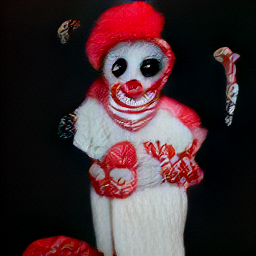

Score: 24.45



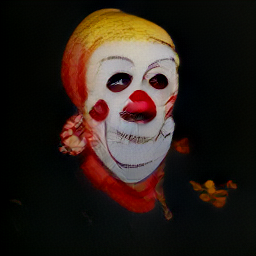

Score: 23.58



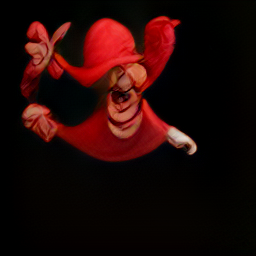

Score: 22.61



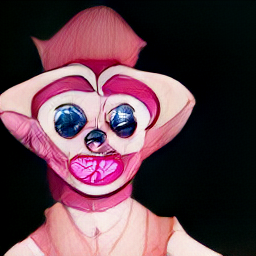

Score: 22.41



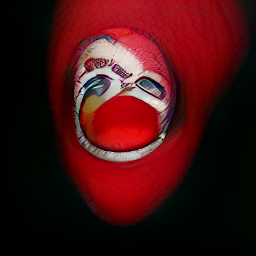

Score: 22.35



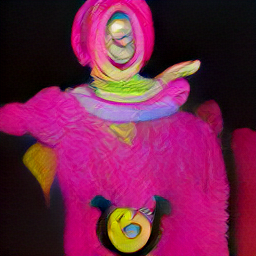

Score: 22.26



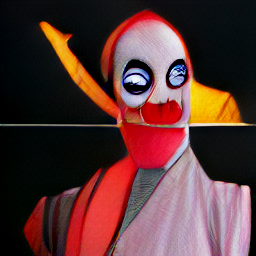

Score: 22.18



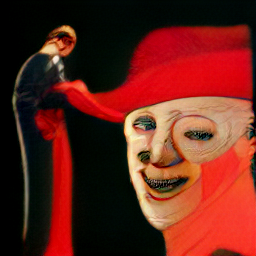

Score: 21.26



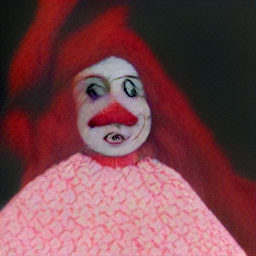

Score: 21.22



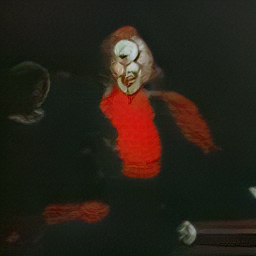

Score: 21.08



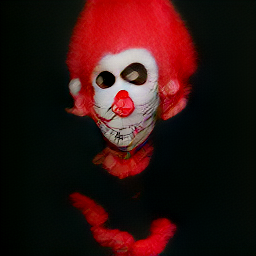

Score: 21.04



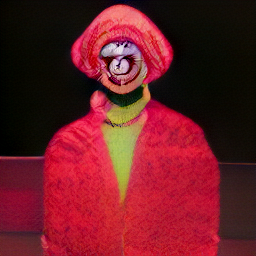

Score: 20.82



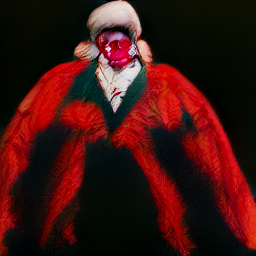

Score: 20.79



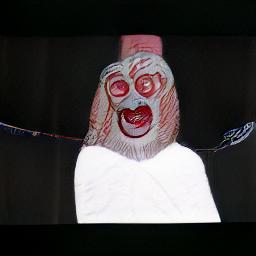

Score: 20.46



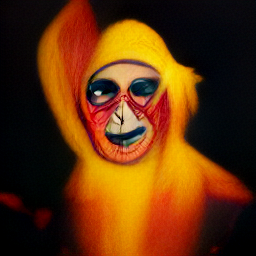

Score: 20.24



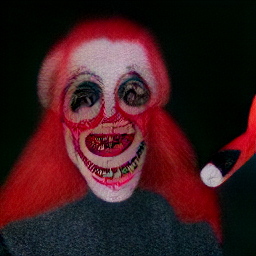

Score: 20.23



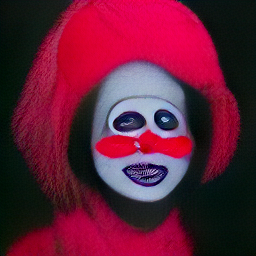

Score: 20.12



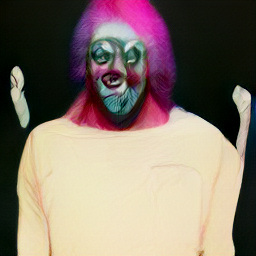

Score: 20.10



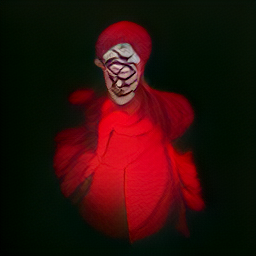

Score: 19.88



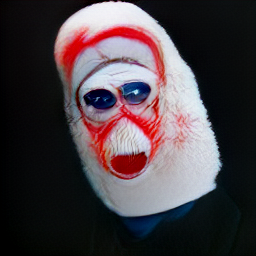

Score: 19.85



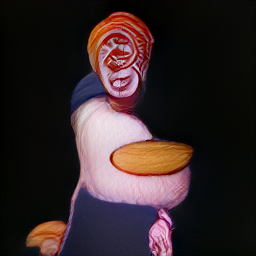

Score: 19.46



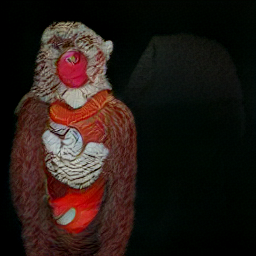

Score: 18.94



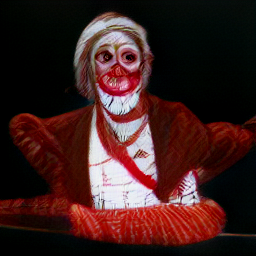

Score: 18.86



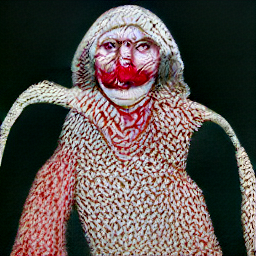

Score: 18.76



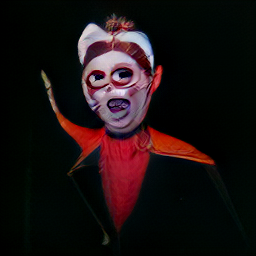

Score: 18.68



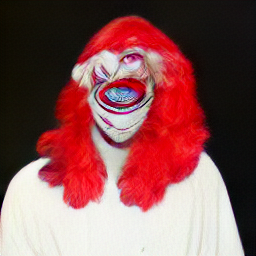

Score: 18.47



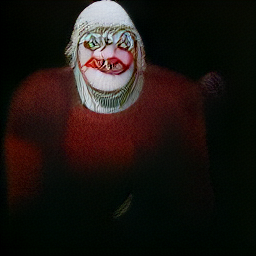

Score: 18.27



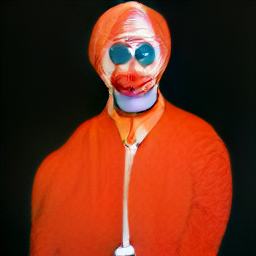

Score: 17.86



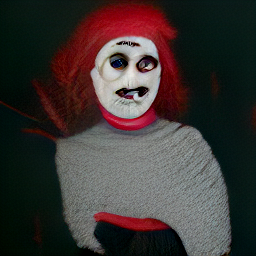

Score: 17.85



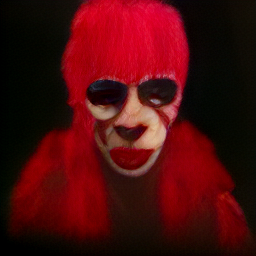

Score: 17.41



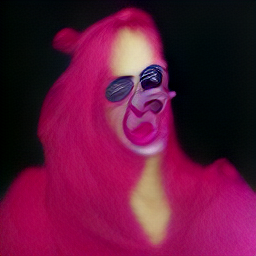

Score: 15.55



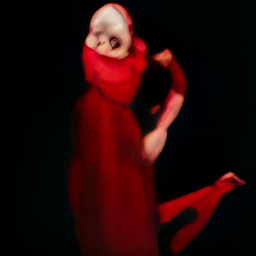

Score: 14.39



In [32]:
print(f"Prompt: {prompt}\n")
for idx in logits.argsort()[::-1]:
    display(images[idx])
    print(f"Score: {logits[idx]:.2f}\n")